# Heat Islant Detection Using CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-12-02 21:03:40.730946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 21:03:40.754261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 21:03:40.761350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 21:03:40.778922: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# x_batches = [np.load(f'X_batch_{i}_{i+1000}.npy') for i in range(0, 2000, 1000)]
# y_batches = [np.load(f'y_batch_thermal_{i}_{i+1000}.npy') for i in range(0, 2000, 1000)]



# # Combine all batches into a single array for X and y
# x = np.concatenate(x_batches, axis=0)
# y = np.concatenate(y_batches, axis=0)



In [3]:
x = np.load('X_batch_2000_3000.npy')
y =  np.load('y_batch_thermal_2000_3000.npy')


In [4]:
x.shape

(1000, 13, 288, 288)

In [5]:
y.shape

(1000, 5, 288, 288)

In [6]:
# lets pick and plot image 100

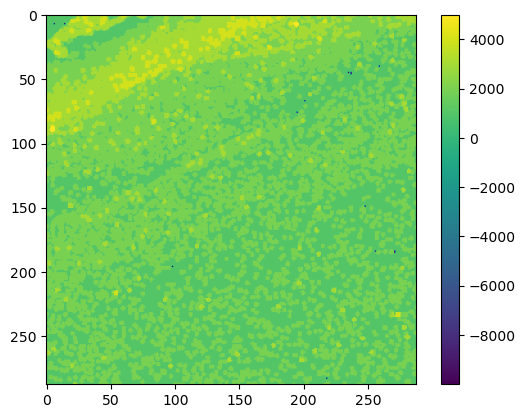

In [7]:
# lidar Return Count - Max
plt.imshow(x[100,1,::])
plt.colorbar()

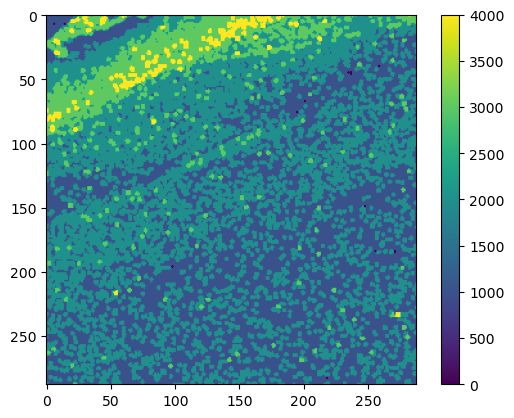

In [8]:
# the negative values there were becuase of -9999 nan values. lets fix it
plt.imshow(x[100,1,::],  vmin=0, vmax=4000)
plt.colorbar()

In [9]:
# lets plot x and y and try to see heat island

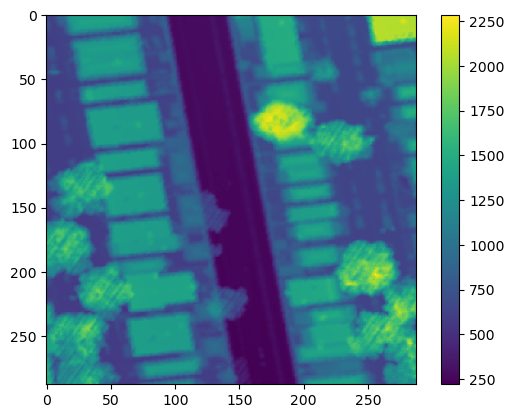

In [10]:
# plot elevation mean
plt.imshow(x[500,6,::])
plt.colorbar()


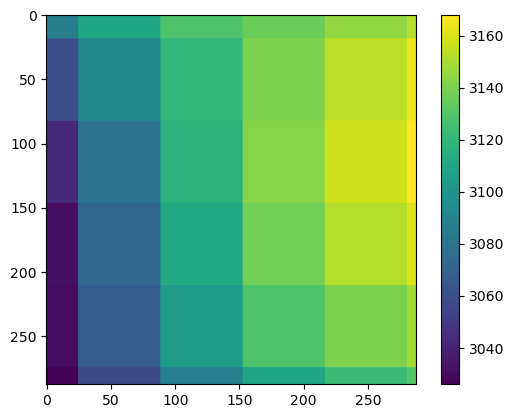

In [11]:
plt.imshow(y[500,1,::])
plt.colorbar()

In [12]:
#why left side is colder than right? doenst make much sense

In [13]:
#***** let's select the needed layers from dataset since we will not work with all of them


In [14]:


x = x[:, :-1, :, :]  # exclude last layers with different value range

y = y[:, :-2, :, :] #exclude last 2 layers

In [15]:
# check shapes  
print(x.shape, y.shape)    

(1000, 12, 288, 288) (1000, 3, 288, 288)


In [16]:
!pip install opencv-python

In [17]:
# ************ 1st interpolation try: complex, old code
import cv2


def fill_missing_with_inpaint(X, no_data_values):
    """
    Fill missing values in a 4D array (loc, layer, n, m) using OpenCV inpainting.

    Parameters:
        X (numpy.ndarray): Input data array with shape (loc, layer, n, m).
        no_data_values (list): List of no-data placeholder values to fill.

    Returns:
        numpy.ndarray: Array with missing values filled.
    """
    X_filled = X.copy()
    for loc in range(X.shape[0]):
        for layer in range(X.shape[1]):
            # Create a mask where missing values are marked
            mask = np.isin(X[loc, layer, :, :], no_data_values).astype(np.uint8)
            # Use inpainting to fill the missing values
            X_filled[loc, layer, :, :] = cv2.inpaint(
                X[loc, layer, :, :].astype(np.float32),  # Input image
                mask,  # Mask indicating missing values
                inpaintRadius=3,  # Radius for inpainting
                flags=cv2.INPAINT_TELEA  # Inpainting algorithm
            )
    return X_filled




In [18]:
# ***** do interpolation
no_data_values = [-9999]
x_filled = fill_missing_with_inpaint(x, no_data_values)


In [19]:
x_filled.shape

(1000, 12, 288, 288)

In [20]:
# lets see how it behaves

In [ ]:
# before interpolation
plt.imshow(x[100,1,::])
plt.colorbar()

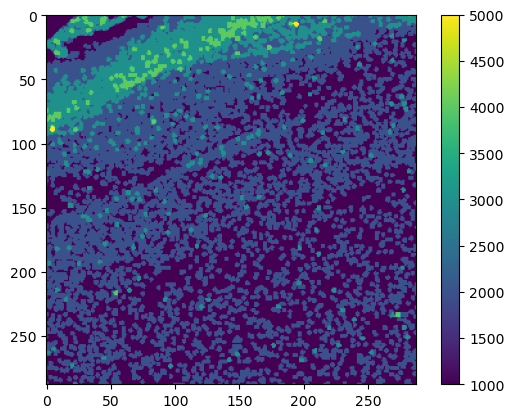

In [22]:
# before interpolation - fixed bars
plt.imshow(x[100,1,::], vmin=1000, vmax = 5000)
plt.colorbar()



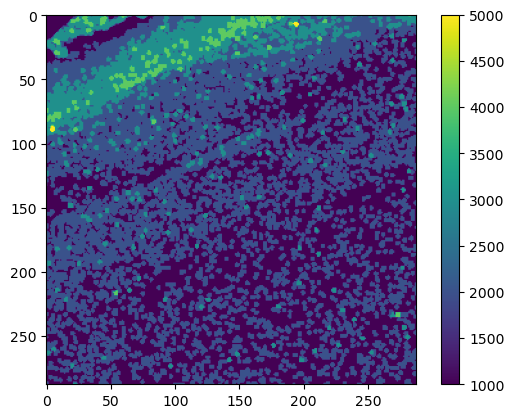

In [23]:
# after interpolation
plt.imshow(x_filled[100,1,::])
plt.colorbar()

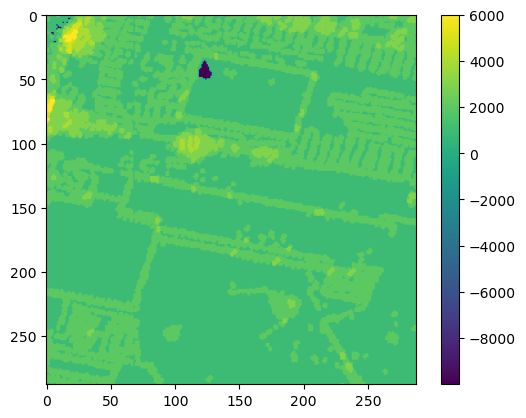

In [24]:
## another example
plt.imshow(x[700,1,::])
plt.colorbar()

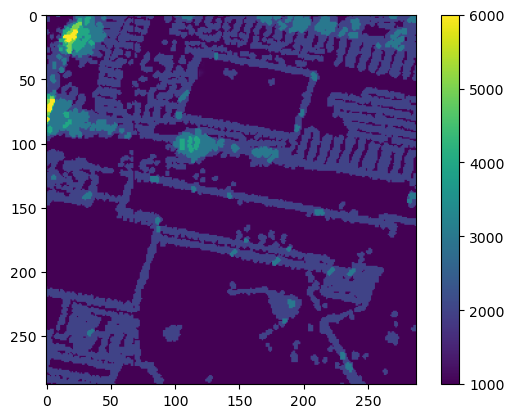

In [25]:
plt.imshow(x_filled[700,1,::])
plt.colorbar()

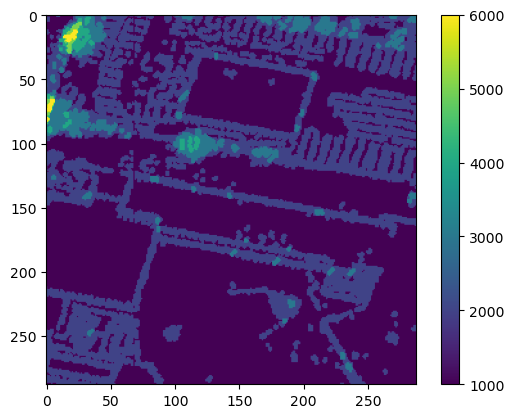

In [26]:
plt.imshow(x[700,1,::], vmin = 1000, vmax = 6000)
plt.colorbar()

In [27]:
## lets see pixel values in histograms

In [28]:
# plt.hist(x_filled[700,1,::])

In [29]:
# plt.hist(x[700,1,::], range=(1000, 6000))


In [30]:
# **************** now lets prepare training dataset *********************#

### X train

In [31]:
# Transpose X_filled to match TensorFlow's input shape (batch_size, height, width, channels)
x_train = x_filled.transpose(0, 2, 3, 1)  # Shape becomes (1000, 288, 288, 13)
x_train.shape

(1000, 288, 288, 12)

### y train

In [32]:
y[0]

array([[[3035, 3035, 3035, ..., 3051, 3051, 3051],
        [3035, 3035, 3035, ..., 3051, 3051, 3051],
        [3035, 3035, 3035, ..., 3051, 3051, 3051],
        ...,
        [2960, 2960, 2960, ..., 2998, 2998, 2998],
        [2960, 2960, 2960, ..., 2998, 2998, 2998],
        [2960, 2960, 2960, ..., 2998, 2998, 2998]],

       [[3218, 3218, 3218, ..., 3302, 3302, 3302],
        [3218, 3218, 3218, ..., 3302, 3302, 3302],
        [3218, 3218, 3218, ..., 3302, 3302, 3302],
        ...,
        [3030, 3030, 3030, ..., 3158, 3158, 3158],
        [3030, 3030, 3030, ..., 3158, 3158, 3158],
        [3030, 3030, 3030, ..., 3158, 3158, 3158]],

       [[2948, 2948, 2948, ..., 3018, 3018, 3018],
        [2948, 2948, 2948, ..., 3018, 3018, 3018],
        [2948, 2948, 2948, ..., 3018, 3018, 3018],
        ...,
        [2798, 2798, 2798, ..., 2907, 2907, 2907],
        [2798, 2798, 2798, ..., 2907, 2907, 2907],
        [2798, 2798, 2798, ..., 2907, 2907, 2907]]], dtype=int16)

In [33]:
y = y/ 100  # convert to celcius

In [34]:
y[0]

array([[[30.35, 30.35, 30.35, ..., 30.51, 30.51, 30.51],
        [30.35, 30.35, 30.35, ..., 30.51, 30.51, 30.51],
        [30.35, 30.35, 30.35, ..., 30.51, 30.51, 30.51],
        ...,
        [29.6 , 29.6 , 29.6 , ..., 29.98, 29.98, 29.98],
        [29.6 , 29.6 , 29.6 , ..., 29.98, 29.98, 29.98],
        [29.6 , 29.6 , 29.6 , ..., 29.98, 29.98, 29.98]],

       [[32.18, 32.18, 32.18, ..., 33.02, 33.02, 33.02],
        [32.18, 32.18, 32.18, ..., 33.02, 33.02, 33.02],
        [32.18, 32.18, 32.18, ..., 33.02, 33.02, 33.02],
        ...,
        [30.3 , 30.3 , 30.3 , ..., 31.58, 31.58, 31.58],
        [30.3 , 30.3 , 30.3 , ..., 31.58, 31.58, 31.58],
        [30.3 , 30.3 , 30.3 , ..., 31.58, 31.58, 31.58]],

       [[29.48, 29.48, 29.48, ..., 30.18, 30.18, 30.18],
        [29.48, 29.48, 29.48, ..., 30.18, 30.18, 30.18],
        [29.48, 29.48, 29.48, ..., 30.18, 30.18, 30.18],
        ...,
        [27.98, 27.98, 27.98, ..., 29.07, 29.07, 29.07],
        [27.98, 27.98, 27.98, ..., 29.07, 29.

In [35]:
y.shape

(1000, 3, 288, 288)

In [36]:
# lets convert y into mean and stdev labels

means = np.mean(y.reshape(1000, -1), axis=1)  # Shape: (1000,)
stds = np.std(y.reshape(1000, -1), axis=1)   # Shape: (1000,)



In [37]:
means.shape

(1000,)

In [38]:
# check calculations of mean and stdev
means[10]

32.03482486175411

In [39]:
np.mean(y[10])

32.03482486175411

In [40]:
stds[10]

1.2118705957412377

In [41]:
np.std(y[10])

1.2118705957412377

In [42]:
# all is fine

In [43]:
mean_std = np.stack((means, stds), axis=1)

In [44]:
mean_std

array([[30.71710512,  1.2203216 ],
       [30.35156925,  1.06688589],
       [30.92110765,  1.25441505],
       ...,
       [28.93565325,  1.27512289],
       [27.63625197,  1.24895214],
       [28.93737771,  1.35481556]])

In [45]:
y_train = mean_std


In [46]:
y_train.shape

(1000, 2)

## Train CNN Model

In [58]:


import tensorflow as tf

# Define input layer with the updated shape
inputs = tf.keras.layers.Input(shape=(288, 288, 12))

# Contracting Path - Encoder
c1 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.BatchNormalization()(c1)  # Batch Normalization
c1 = tf.keras.layers.Activation('relu')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.BatchNormalization()(c1)  # Batch Normalization
c1 = tf.keras.layers.Activation('relu')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.BatchNormalization()(c2)  # Batch Normalization
c2 = tf.keras.layers.Activation('relu')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.BatchNormalization()(c2)  # Batch Normalization
c2 = tf.keras.layers.Activation('relu')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)


#bottleneck
c3 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.BatchNormalization()(c3)  # Batch Normalization
c3 = tf.keras.layers.Activation('relu')(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
c3 = tf.keras.layers.BatchNormalization()(c3)  # Batch Normalization
c3 = tf.keras.layers.Activation('relu')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# Bottleneck
c4 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.BatchNormalization()(c4)  # Batch Normalization
c4 = tf.keras.layers.Activation('relu')(c4)
c4 = tf.keras.layers.Dropout(0.3)(c4)
c4 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.BatchNormalization()(c4)  # Batch Normalization
c4 = tf.keras.layers.Activation('relu')(c4)


flattened = tf.keras.layers.GlobalAveragePooling2D()(c4)  # Flatten bottleneck feature maps

# first dense layer
dense1 = tf.keras.layers.Dense(64, kernel_initializer='he_normal')(flattened)
dense1 = tf.keras.layers.BatchNormalization()(dense1)  # Batch Normalization
dense1 = tf.keras.layers.Activation('relu')(dense1)


# second dense layer
dense2 = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)  # Batch Normalization
dense2 = tf.keras.layers.Activation('relu')(dense2)

outputs = tf.keras.layers.Dense(2, activation='linear')(dense2)  # Predict mean and stdev

# Create and compile the model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean Squared Error for regression


# callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_with_early_stopping_last.keras.keras',  # Filepath to save the model
    monitor='val_loss',          # Monitor validation loss
    save_best_only=True,         # Save only the best model
    save_weights_only=False,     # Save the entire model
    mode='min',                  # Minimize the validation loss
    verbose=1                    # Print updates during training
)

# Define the EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=10,                # Stop after 10 epochs with no improvement
    restore_best_weights=True,  # Restore the best weights after stopping
    mode='min',                 # Minimize the validation loss
    verbose=1                   # Print when stopping
)

# Train the model
history = model.fit(
    x_train,           # Input data (12-channel LiDAR images)
    y_train,          # Labels (mean and standard deviation vectors)
    validation_split=0.2,
    batch_size= 16,
    epochs=50,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save the model
model.save('best_model_with_early_stopping_last.keras')


2024-12-02 21:14:33.230969: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1592524800 exceeds 10% of free system memory.


Epoch 1/50


/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_166']. Received: the structure of inputs=*
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 332.2743 - mae: 13.4892
Epoch 1: val_loss improved from inf to 330.28848, saving model to best_model_with_early_stopping_last.keras.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - loss: 332.2561 - mae: 13.4880 - val_loss: 330.2885 - val_mae: 13.0340
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 305.1490 - mae: 12.7037
Epoch 2: val_loss improved from 330.28848 to 318.74991, saving model to best_model_with_early_stopping_last.keras.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 305.0287 - mae: 12.7004 - val_loss: 318.7499 - val_mae: 13.3527
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 273.9172 - mae: 11.8970
Epoch 3: val_loss improved from 318.74991 to 269.10123, saving model to best_model_with_early_stopping_last.keras.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 273.8257 - mae: 11.8943 - val_loss: 269.1012 - val_mae: 11.8393
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 246.4019 - 

In [59]:
# load the model
model_path = 'best_model_with_early_stopping_modified.keras'
loaded_model = tf.keras.models.load_model(model_path)

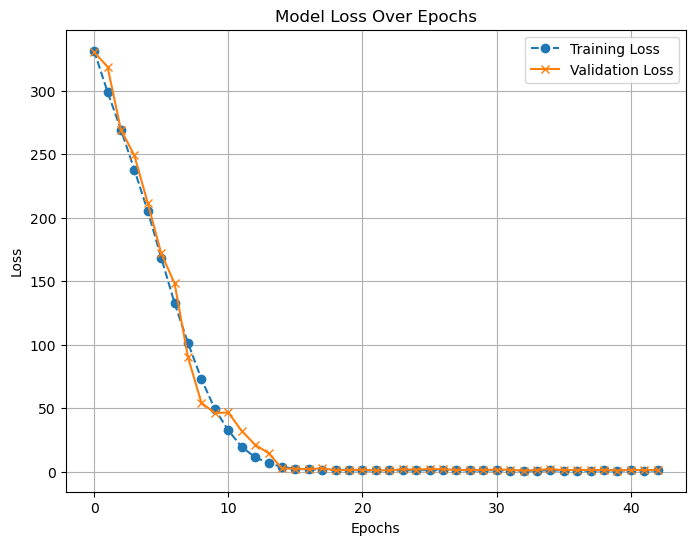

In [60]:
# Extract metrics from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', linestyle='--', marker='o')
plt.plot(val_loss, label='Validation Loss', linestyle='-', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.savefig('simple_thermal_unet_model_with_interpolation.keras.loss.png', dpi=300, bbox_inches='tight') 






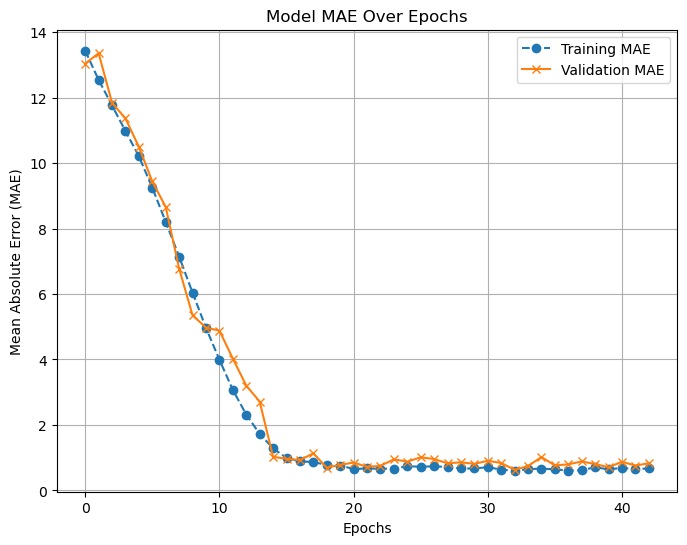

In [61]:
# Plot Training and Validation MAE
plt.figure(figsize=(8, 6))
plt.plot(train_mae, label='Training MAE', linestyle='--', marker='o')
plt.plot(val_mae, label='Validation MAE', linestyle='-', marker='x')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)


plt.savefig('simple_thermal_unet_model_with_interpolation.keras.mae.png', dpi=300, bbox_inches='tight') 

### Predictions on train data

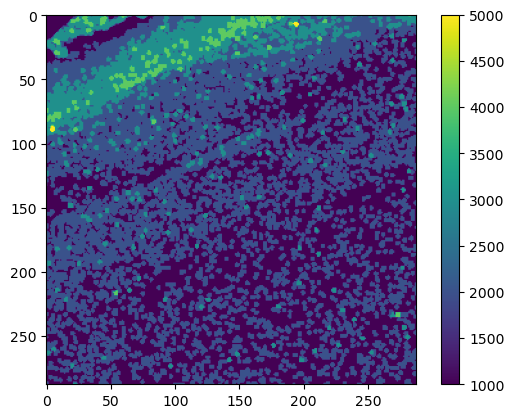

In [65]:
# Select one sample

sample_idx = 100  # Index of the sample to evaluate
x_sample = x_train[sample_idx]  # Shape: (13, 288, 288)
y_original = mean_std[sample_idx]  # Shape: (288, 288)

plt.imshow(x_train[sample_idx,:,:, 1])
plt.colorbar()

In [66]:
# Run the sample through the model to get predictions
total = 10
errors = []
results = []
for sample_idx in range(0, total):
    
    x_sample  = x_train[sample_idx]
    x_sample = np.expand_dims(x_sample, axis=0)  # Add batch dimension (1, 13, 288, 288)
    predicted = model.predict(x_sample)  # Output shape: (1, 288, 288, 1)
    predicted = predicted.squeeze()  # Remove extra dimensions, shape becomes (288, 288)
    original = mean_std[sample_idx]
    # print(predicted - 
    # print(mean_std[sample_idx])
    errors.append((predicted - mean_std[sample_idx])**2 )
    results.append([predicted, original])




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [67]:
results

[[array([29.725039 ,  1.2975105], dtype=float32),
  array([20.8714349 ,  0.78682991])],
 [array([28.32448  ,  1.2193124], dtype=float32),
  array([24.37828836,  0.53649119])],
 [array([29.214636 ,  1.2336998], dtype=float32),
  array([23.82496902,  0.70312288])],
 [array([28.031746 ,  1.1565845], dtype=float32),
  array([22.60774587,  0.69518479])],
 [array([28.804285 ,  1.2113075], dtype=float32),
  array([21.46310298,  0.78826041])],
 [array([29.375122 ,  1.2860117], dtype=float32),
  array([25.59554475,  0.42979377])],
 [array([29.48169,  1.2774 ], dtype=float32),
  array([25.45946398,  0.53783799])],
 [array([29.152859 ,  1.2093885], dtype=float32),
  array([24.6664597 ,  0.87421719])],
 [array([29.215477 ,  1.2532114], dtype=float32),
  array([24.11838389,  0.83630458])],
 [array([29.365984 ,  1.2710664], dtype=float32),
  array([26.90701212,  0.98188753])]]

## Run Inference

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [108]:
x = np.load('X_batch_1000_2000.npy')
y =  np.load('y_batch_thermal_1000_2000.npy')


x = x[:, :-1, :, :]  # exclude last layers with different value range

y = y[:, :-2, :, :]

no_data_values = [-9999]
x_filled = fill_missing_with_inpaint(x, no_data_values)
x_test = x_filled.transpose(0, 2, 3, 1)

y = y/ 100  # convert to celcius

means = np.mean(y.reshape(1000, -1), axis=1)  # Shape: (1000,)
stds = np.std(y.reshape(1000, -1), axis=1)   # Shape: (1000,)
mean_std = np.stack((means, stds), axis=1)

y_test = mean_std 


In [80]:
!pip install visualkeras

  Using cached visualkeras-0.1.4-py3-none-any.whl.metadata (11 kB)
  Using cached aggdraw-1.3.19-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (655 bytes)
Using cached visualkeras-0.1.4-py3-none-any.whl (17 kB)
Using cached aggdraw-1.3.19-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)


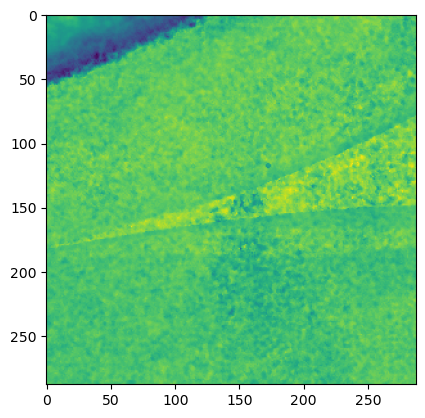

In [110]:
plt.imshow(x_test[0,:,:,6])

In [83]:
import visualkeras

img = visualkeras.layered_view(
    model, 
    scale_xy=0.5,  # Scale the x and y dimensions of the layers
    scale_z=0.5,
    legend=True)

img.save("model_visualization.png")

In [84]:

total = 100
predicted_means = []
original_means = []
predicted_stds = []
original_stds = []

# Loop over the test dataset
for sample_idx in range(0, total):
    # Get a single test sample (shape: (288, 288, 12) for LiDAR data)
    x_sample = x_test[sample_idx]
    x_sample = np.expand_dims(x_sample, axis=0)  # Add batch dimension (1, 288, 288, 12)
    
    # Run the model to predict mean and std for the current sample
    predicted = model.predict(x_sample)  # Output shape: (1, 2) -> [mean, std]
    predicted = predicted.squeeze()  # Remove batch dimension, shape becomes (2,)
    
    # Get the original mean and std from y_test
    original = y_test[sample_idx]  # Shape: (2,)
    
    # Store the predicted and original values for plotting
    predicted_means.append(predicted[0])
    predicted_stds.append(predicted[1])
    original_means.append(original[0])
    original_stds.append(original[1])

# Convert lists to NumPy arrays for easier plotting
predicted_means = np.array(predicted_means)
predicted_stds = np.array(predicted_stds)
original_means = np.array(original_means)
original_stds = np.array(original_stds)






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

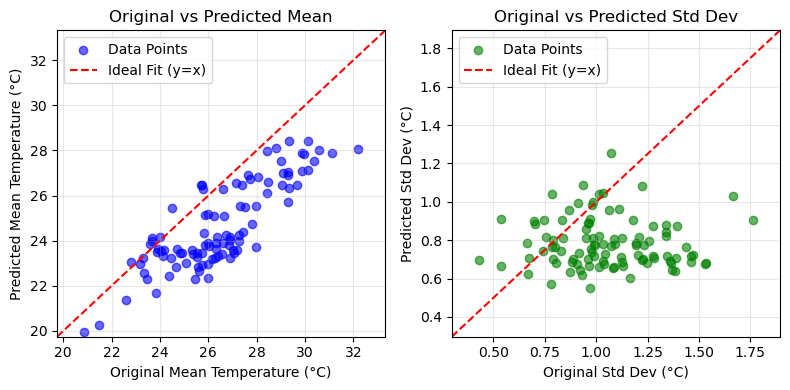

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate limits dynamically with a margin
mean_margin = 0.1 * (max(original_means) - min(original_means))
mean_xlim = [min(original_means) - mean_margin, max(original_means) + mean_margin]

std_margin = 0.1 * (max(original_stds) - min(original_stds))
std_xlim = [min(original_stds) - std_margin, max(original_stds) + std_margin]

# Scatter Plot for Mean
plt.figure(figsize=(8, 4))

# Mean
plt.subplot(1, 2, 1)
plt.scatter(original_means, predicted_means, c='blue', alpha=0.6, label="Data Points")
plt.plot(mean_xlim, mean_xlim, color='red', linestyle='--', label="Ideal Fit (y=x)")
plt.title("Original vs Predicted Mean")
plt.xlim(mean_xlim)
plt.ylim(mean_xlim)
plt.xlabel("Original Mean Temperature (°C)")
plt.ylabel("Predicted Mean Temperature (°C)")
plt.legend()
plt.grid(alpha=0.3)

# Standard Deviation
plt.subplot(1, 2, 2)
plt.scatter(original_stds, predicted_stds, c='green', alpha=0.6, label="Data Points")
plt.plot(std_xlim, std_xlim, color='red', linestyle='--', label="Ideal Fit (y=x)")
plt.title("Original vs Predicted Std Dev")
plt.xlabel("Original Std Dev (°C)")
plt.ylabel("Predicted Std Dev (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(std_xlim)
plt.ylim(std_xlim)

# Show the plots
plt.tight_layout()
plt.savefig("final_regression_plots_optimized.png", dpi=300)
plt.show()


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


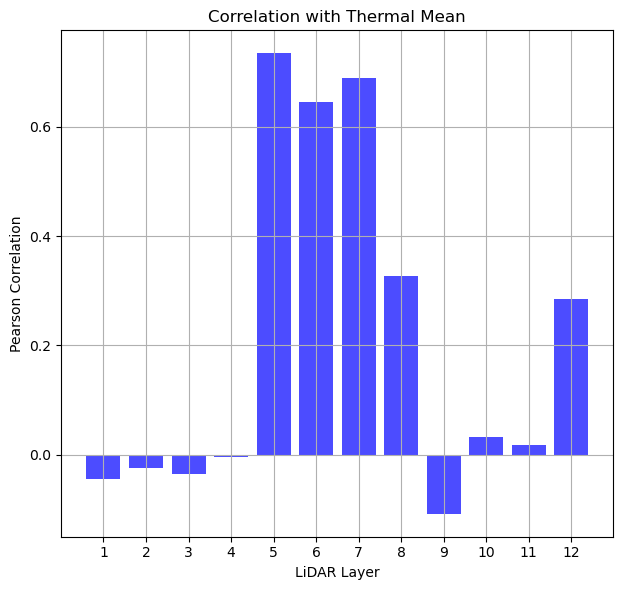

In [100]:

from scipy.stats import pearsonr


mean_correlations = []
std_correlations = []

# Loop through each LiDAR layer (last dimension in x_test)
for i in range(x_test.shape[-1]):
    # Flatten the LiDAR layer for all samples
    lidar_layer = x_test[:, :, :, i].reshape(x_test.shape[0], -1).mean(axis=1)
    print(lidar_layer.shape)
    # Compute correlation with the mean of the thermal data
    mean_corr, _ = pearsonr(lidar_layer, y_test[:, 0])  # Correlation with mean
   # std_corr, _ = pearsonr(lidar_layer, y_test[:, 1])   # Correlation with std
    
    mean_correlations.append(mean_corr)
    std_correlations.append(std_corr)

# Visualize correlations
plt.figure(figsize=(12, 6))

# Bar plot for mean correlation
plt.subplot(1, 2, 1)
plt.bar(range(1, x_test.shape[-1] + 1), mean_correlations, color='blue', alpha=0.7)
plt.title("Correlation with Thermal Mean")
plt.xlabel("LiDAR Layer")
plt.ylabel("Pearson Correlation")
plt.xticks(range(1, x_test.shape[-1] + 1))
plt.grid()


plt.tight_layout()
plt.savefig("lidar_correlation_analysis.png", dpi=300, bbox_inches="tight")
plt.show()


In [101]:
#Elevation - Min Elevation - Max Elevation - Mean Elevation - Std correspond to layers 5-8, which show the highest correlation